Functional alignment on a pair of subject
===================================================================

In this tutorial, we show how to better predict new contrasts for a target subject using source subject corresponding contrasts and data in common.

We mostly rely on python common packages and on nilearn to handle functional data in a clean fashion.


To run this example, you must launch IPython via ``ipython
--matplotlib`` in a terminal, or use ``jupyter-notebook``.

.. contents:: **Contents**
    :local:
    :depth: 1

Retrieving the data
-------------------
In this example we use the IBC dataset, which include a large number of different contrasts maps for 12 subjects

We download the images for subjects 1 and 2 (or retrieve them if they were already downloaded)

Files is the list of paths for each subjects. df is a dataframe with metadata about each of them, mask is an appropriate nifti image to select the data.

In [5]:
from fmralign.fetch_example_data import fetch_ibc_subjects_contrasts
files, df, mask = fetch_ibc_subjects_contrasts(
    ['sub-01', 'sub-02'])

Defining a masker
-----------------
Using the mask provided, define a nilearn masker that will be used to handle relevant data

For more information, visit : http://nilearn.github.io/manipulating_images/masker_objects.html


In [6]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask)
mask
masker.fit()

NiftiMasker(detrend=False, high_pass=None, low_pass=None, mask_args=None,
      mask_img='/Users/thomasbazeille/nilearn_data/ibc/gm_mask_3mm.nii.gz',
      mask_strategy='background', memory=Memory(cachedir=None),
      memory_level=1, sample_mask=None, sessions=None, smoothing_fwhm=None,
      standardize=False, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

Separate the retrieved files into four folds
---------------------------------------------
The train folds used to learn alignment from source subject toward target:
* source train: AP contrasts for subject one
* target train: AP contrasts for subject two

The test folds:
* source test: PA contrasts for subject one, used to predict the corresponding contrasts of subject two
* target test: PA contrasts for subject two, used as a ground truth to score our predictions

In [13]:
source_train = df[df.subject == 'sub-01'][df.acquisition == 'ap'].path.values
target_train = df[df.subject == 'sub-02'][df.acquisition == 'ap'].path.values
source_test = df[df.subject == 'sub-01'][df.acquisition == 'pa'].path.values
target_test = df[df.subject == 'sub-02'][df.acquisition == 'pa'].path.values
print(source_train)

[ '/Users/thomasbazeille/nilearn_data/ibc/sub-01/audio_left_button_press_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/audio_right_button_press_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/video_left_button_press_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/video_right_button_press_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/horizontal_checkerboard_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/vertical_checkerboard_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/audio_sentence_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/video_sentence_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/audio_computation_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/video_computation_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/saccades_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/rotation_hand_ap.nii.gz'
 '/Users/thomasbazeille/nilearn_data/ibc/sub-01/rotation_s

/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/thomasbazeille/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Define the estimator used to align subjects, fit it and use it to predict
-------------------------------------------------------------------------
To proceed with alignment we use PairwiseAlignment class.
We will use the common model proposed in the literature:
* we will align the whole brain through multiple local alignments.
* these alignments are calculated on a parcellation of the brain in 150 pieces, this parcellation creates group of functionnally similar voxels.

In [8]:
from fmralign.pairwise_alignment import PairwiseAlignment
alignement_estimator = PairwiseAlignment(
    alignment_method='scaled_orthogonal', n_pieces=150, mask=masker)
# Learn alignment operator for source subject 1 to target subject 2 on training data
alignement_estimator.fit(source_train, target_train)
# Predict test data for subject 2 from subject 1
target_pred = alignement_estimator.transform(source_test)

/Users/thomasbazeille/.local/lib/python2.7/site-packages/nilearn/input_data/masker_validation.py:74: UserWarning: Overriding provided-default estimator parameters with provided masker parameters :
Parameter standardize :
    Masker parameter False - overriding estimator parameter None

  warnings.warn(warn_str)


Score the prediction of test data without alignment
---------------------------------------------------
To score the quality of prediction we use r2 score on each voxel activation profile across contrasts
This score is 1 for a perfect prediction and can get arbitrarly bad (here we clip it to -1 for bad predictions)

In [9]:
import numpy as np
from sklearn.metrics import r2_score

# The baseline score represents the quality of prediction using raw data
baseline_score = np.maximum(r2_score(
    masker.transform(target_test), masker.transform(source_test), multioutput='raw_values'), -1)
# The baseline score represents the quality of prediction using aligned data
aligned_score = np.maximum(r2_score(
    masker.transform(target_test), masker.transform(target_pred), multioutput='raw_values'), - 1)

Plotting the prediction quality
---------------------------------------------------

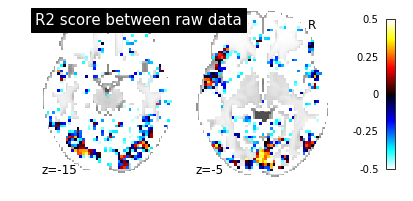

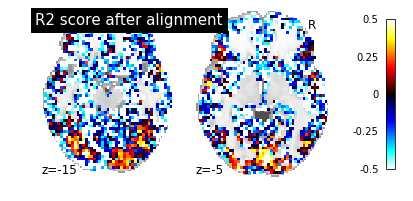

In [12]:
from nilearn.plotting import plot_stat_map
%matplotlib inline

baseline_display = plot_stat_map(masker.inverse_transform(
    baseline_score), display_mode="z", vmax=0.5, cut_coords=[-15, -5])
baseline_display.title("R2 score between raw data")

display = plot_stat_map(
    masker.inverse_transform(
        aligned_score), display_mode="z", cut_coords=[-15, -5], vmax=0.5)
display.title("R2 score after alignment")

We can see on the plot that after alignment the prediction made for one subject data, informed by another subject are greatly improved